## Part One: EDA
<div class="span5 alert alert-info">
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.
</div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

sns.set()

In [31]:
log = pd.read_json('ultimate_challenge/logins.json')
print(log.info())
print(log.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


In [34]:
log.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


There are duplicate login times in the data, which may or may not be erroneous depending on the purpose of the dataset. If the purpose of the login time is only to check for activity irregardless of the number of users, then it might make sense to only keep the unique values. Also, since the times are not matched with a user ID, it is difficult to determine if the duplicate values are errors or are multiple users logging in at the same time. In this case, the purpose is to describe patterns of user demand, and no other information is provided about the data, so I will proceed keeping all login times in the dataset. 

In [92]:
# number of logins per 15 minute interval
login_count = log.reset_index().set_index('login_time').resample('15T').count()
login_count.rename(columns={'index':'count'}, inplace=True)
login_count.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [93]:
login_count.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


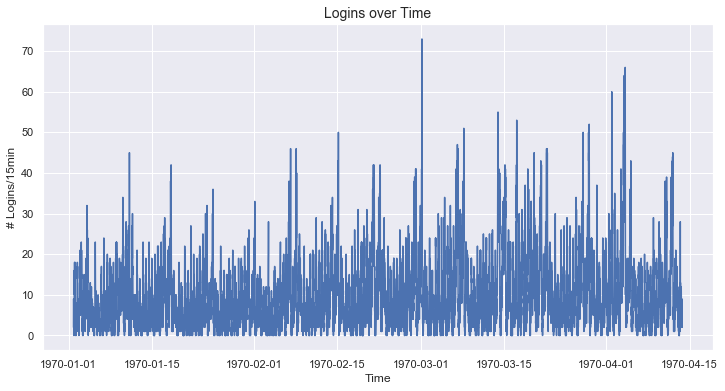

In [102]:
pylab.rcParams['figure.figsize'] = (12.0, 6.0)

plt.plot(login_count['count'])
plt.xlabel('Time')
plt.ylabel('# Logins/15min')
plt.title('Logins over Time', size=14)
plt.show()

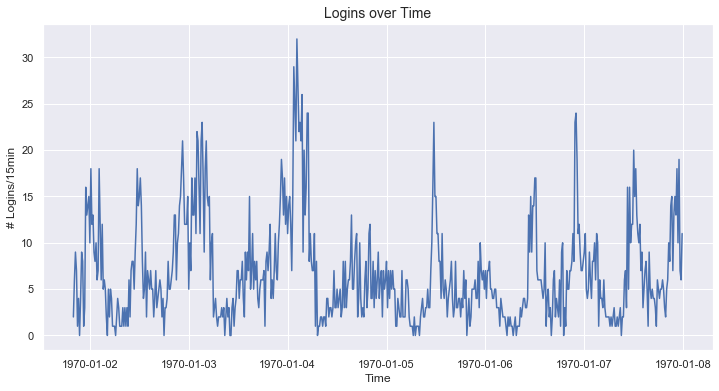

In [107]:
plt.plot(login_count['count'][:'1-07-1970'])
plt.xlabel('Time')
plt.ylabel('# Logins/15min')
plt.title('Logins over Time', size=14)
plt.show()

There appears to be high daily cyclicality in the data, which is confirmed in the boxplots below. Throughout the day, the logins peak at night and around noon.

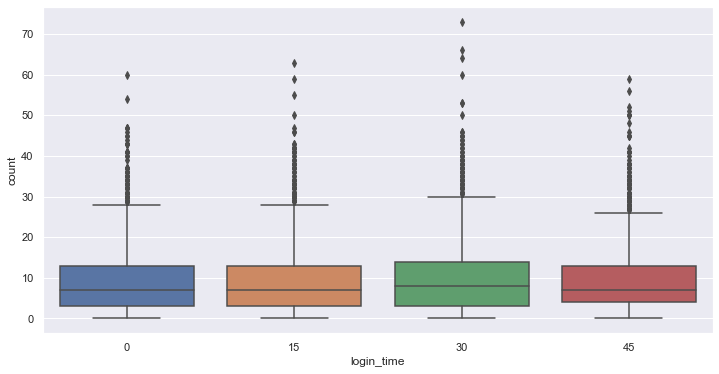

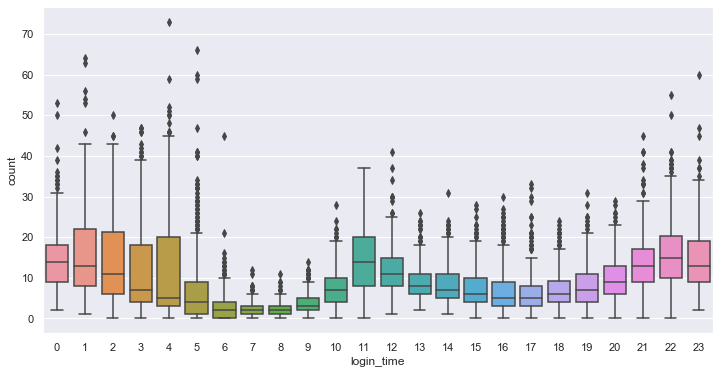

In [108]:
sns.boxplot(login_count.index.minute, login_count['count'])
plt.show()

sns.boxplot(login_count.index.hour, login_count['count'])
plt.show()

In [95]:
login_count['dayofweek'] = login_count.index.dayofweek
login_count['dayofmonth'] = login_count.index.day
login_count['month'] = login_count.index.month

print(login_count.head(5))

                     count  dayofweek  dayofmonth  month
login_time                                              
1970-01-01 20:00:00      2          3           1      1
1970-01-01 20:15:00      6          3           1      1
1970-01-01 20:30:00      9          3           1      1
1970-01-01 20:45:00      7          3           1      1
1970-01-01 21:00:00      1          3           1      1


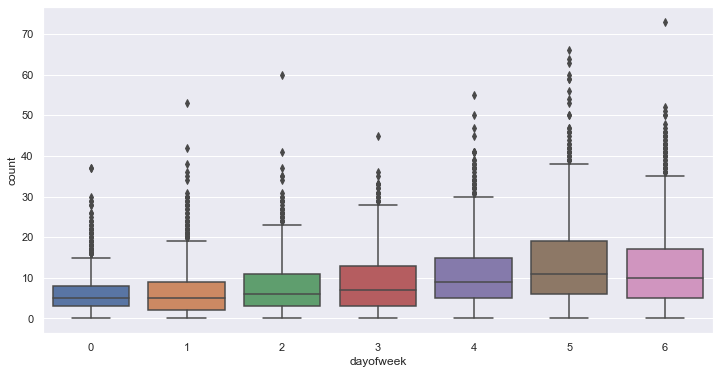

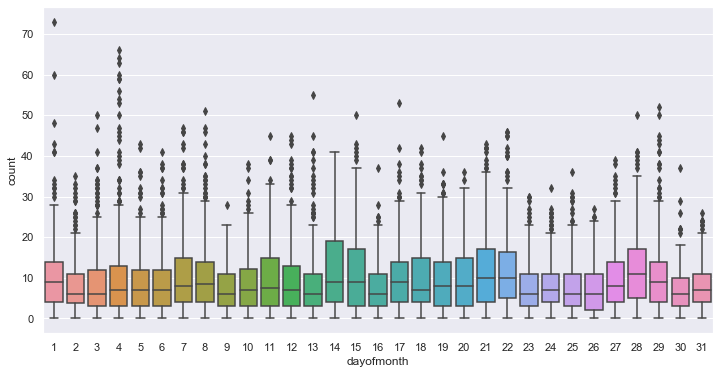

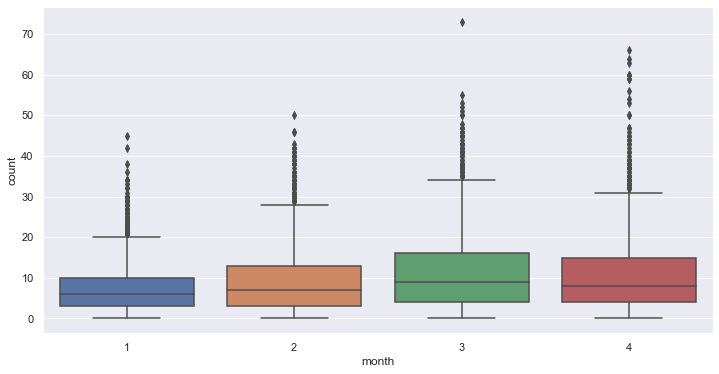

In [104]:
sns.boxplot(login_count['dayofweek'], login_count['count'])
plt.show()

sns.boxplot(login_count['dayofmonth'], login_count['count'])
plt.show()

sns.boxplot(login_count['month'], login_count['count'])
plt.show()

The key takeaways are that saturadays appear to have the most logins, and there are more logins late at night or around lunchtime. Total user logins seem to have increased in months 3 and 4 compared to earlier months.

## Part 2 ‑ Experiment and metrics design
<div class="span5 alert alert-info">
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 
  
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
</div>

The purpose of the experiment is to try and increase the number of available drivers to presumably meet unmet customer demands. For this problem, I assume that the demand and driver base stays relatively constant over the experiment period, otherwise additional considerations are necessary. With this in mind, Ultimate could measure the success of the experiment in two steps:  
1. Did the toll reimbursements significantly increase the number of cross city drivers and cross city trips?
    - If Ultimate has a database of the drivers' listing their city of residence/operation and short term updates on trip data, they can measure the number of cross city drivers as those who meet a minimum number of trips on the opposite side. The total number of cross city trips can also be counted. These metrics will be reported as the average number on the week and weekend. It is important to separate the week and weekend metrics since the customer demand is very different.
2. If part 1 is true, is the net difference in profit/customer satisfaction attributable to the change positive? 
    - The end goal of the toll reimbursement would be to either increase the company profits or customer satisfaction/customer base (and therefore future company profits). If drivers claiming reimbursements are costing the company rather than paying off, it may not be worthwhile for the company to reimburse all toll costs and they might set a limit on the amount of reimbursements. For example, in the case that the highest weekend activity is near the toll borders, drivers might cross the toll at a high rate, costing the company more and decreasing the profit. One simplified metric the company could look at is the 'change in the number of cross city drivers /(change in revenue - toll reimbursements)'. That is, for each additional cross city driver, how much is the company earning/losing? Alternatively, if Ultimate is more concerned with increasing customer satisfaction, they could use a after-ride satisfaction survey. In that case, they can use the change in customer satisfaction in place of the change in profit. Similarly, they could use the change in the average number of customers/trips as a denominator.

<div class="span5 alert alert-info">
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the observation
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
/div>

For the purpose of this problem, I'll use a test implementation of one month. First, calculate or measure the average number of cross city drivers and cross city trips for the month before the toll reimbursement starts. If historical data is available, then the toll reimbursement can be immediately enacted for the next month. After the data is collected, calculate the average number of cross city drivers and cross city trips on the weekdays and weekends.   
A one-sided t-test can be used to test the null hyposthes that the number of cross city drivers/cross city trips during the weekdays/weekend is not significantly more than before. If the reimbursements do not have a significantly positive effect on the number of cross city drivers or cross city trips, then the reimbursement initiative would likely be uneffective. The exception to this is if there is a marked trend of increasing numbers, but the average is not significant, suggesting that a longer implementation could yield significance. If the reimbursements have a significantly positive effect (the null hypothesis is rejected), move on to step two of the evaluation.  
In step two, calculate and test for significance in one or all of the following: change in revenue less toll reimbursements, change in customer satisfaction, change in the average number of customers/trips. The significance can tested with a one or two-sided t-test. These metrics can be compared against the change in the number of cross city drivers/cross city trips to show the effect of the toll reimbursements. Depending on the goal of the company, some metrics may be more important than others. Suppose the company is most concerned with gaining more customers/increasing the number of trips to gain market share. Then they may be willing to decrease profits to gain more customers. When making recommendations, it is also important to look at weekday and weekends separately. For example, the toll reimbursement might not make a huge difference on the weekdays when demand at any given time is primarily in one city or the other, but has a significant effect on weekends. Then the company would be recommended to provide toll reimbursements on weekends but not on weekdays. 


## Part 3 ‑ Predictive modeling
<div class="span5 alert alert-info">
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.  
 
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.  
  
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.  
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).
</div>

### Data Cleaning

In [3]:
import json

In [95]:
# load json file as a dataframe
with open('ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)

ult = pd.DataFrame(data)

print(ult.info())
ult.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


There are a mix of categorical, continuous, and date variables. avg_rating_of_driver, phone, and avg_rating_by_driver all have some missing values.

In [96]:
ult['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [97]:
# fill in missing values with mean value
ult['avg_rating_of_driver'].fillna(ult['avg_rating_of_driver'].mean(),inplace=True)
ult['avg_rating_by_driver'].fillna(ult['avg_rating_by_driver'].mean(),inplace=True)
ult['phone'].fillna('iPhone',inplace=True)

In [98]:
ult.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


trips_in_first_30_days, surge_pct, and avg_dist seem to have outliers since the max value is much higher than the 75th percentile. weekday_pct and surge_pct have a high standard deviation.

In [99]:
# drop signup_date
ult.drop('signup_date', axis=1, inplace=True)

In [100]:
# convert dates to datetime format
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])

# find the most recent date
last_dt = max(ult['last_trip_date'])
print(last_dt)
print(last_dt - pd.Timedelta('30D'))

# add retained as binary variable to data
ult['retained'] = (ult['last_trip_date'] >= (last_dt - pd.Timedelta('30D')))*1
ult['retained'].head()

# drop last_trip_date
ult.drop('last_trip_date', axis=1, inplace=True)

2014-07-01 00:00:00
2014-06-01 00:00:00


In [101]:
# convert ultimate_black_user to binary variable
ult['ultimate_black_user'] = ult['ultimate_black_user']*1

In [102]:
# One Hot Encode categorical variables
cat_var = ['city', 'phone']
ult = pd.get_dummies(ult, columns=cat_var)
ult.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [103]:
ult.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

### EDA

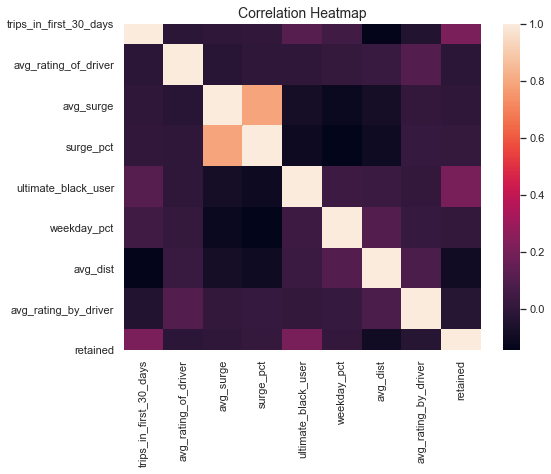

In [104]:
# plot heatmap of cont. variables
corr = ult.loc[:,:'retained'].corr()

plt.subplots(figsize=(8, 6))
sns.heatmap(corr)
plt.title('Correlation Heatmap', size=14);

avg_surge and surge_pct are highly positively correlated, since they are both related to trips during price surges.

In [105]:
# how do the features corr with the target?
corr['retained'].sort_values()

avg_dist                 -0.092780
avg_rating_by_driver     -0.026748
avg_rating_of_driver     -0.010829
avg_surge                -0.003333
weekday_pct               0.009693
surge_pct                 0.011797
ultimate_black_user       0.205002
trips_in_first_30_days    0.210463
retained                  1.000000
Name: retained, dtype: float64

trips_in_first_30_days and ultimate_black_user have the highest correlation with the target variable. Interestingly, avg_surge is slightly negatively correlated while surge_pct is slightly positively correlated with the retension. However they are positively correlated with each other.

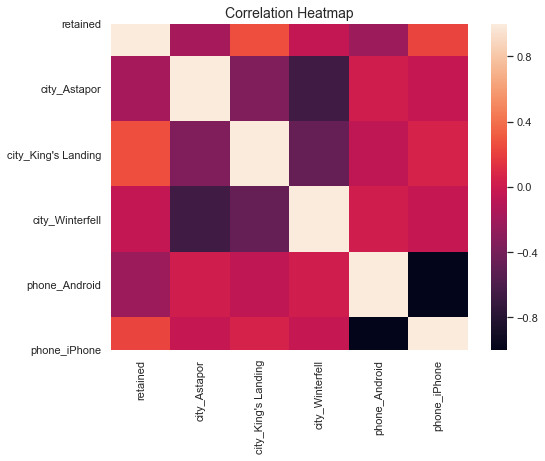

In [106]:
# plot heatmap of cat. variables
corr = ult.loc[:,'retained':].corr()

plt.subplots(figsize=(8, 6))
sns.heatmap(corr)
plt.title('Correlation Heatmap', size=14);

In [107]:
# how do the features corr with the target?
corr['retained'].sort_values()

phone_Android         -0.225464
city_Astapor          -0.174655
city_Winterfell       -0.046611
phone_iPhone           0.225464
city_King's Landing    0.262284
retained               1.000000
Name: retained, dtype: float64

King's Landing has the highest retension rate, which is reflected in it's correlation with the target variable. iPhone users are positively correlated with retension while Android users are negatively correlated.

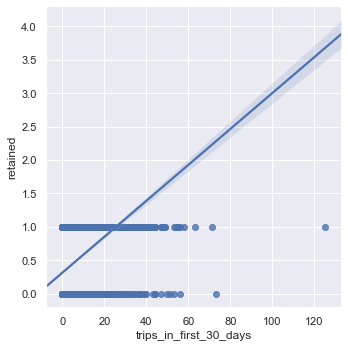

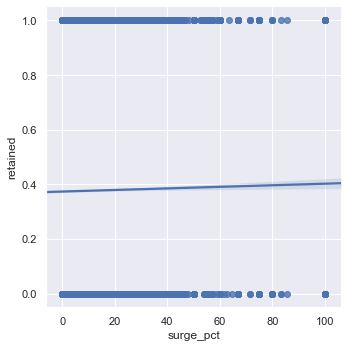

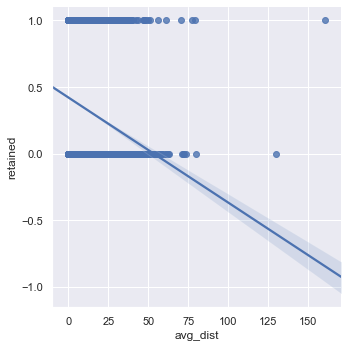

In [108]:
sns.lmplot(x='trips_in_first_30_days',y='retained',data=ult)
sns.lmplot(x='surge_pct',y='retained',data=ult)
sns.lmplot(x='avg_dist',y='retained',data=ult);

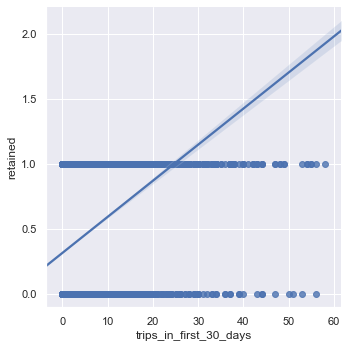

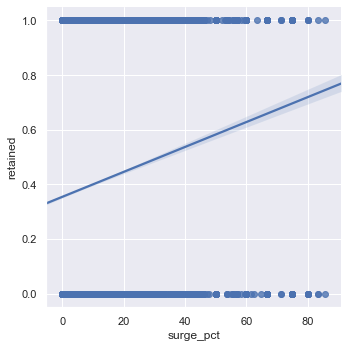

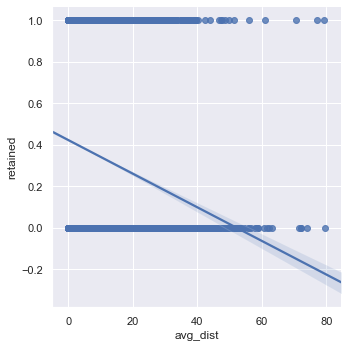

In [109]:
sns.lmplot(x='trips_in_first_30_days',y='retained',data=ult[ult['trips_in_first_30_days']<60])
sns.lmplot(x='surge_pct',y='retained',data=ult[ult['surge_pct']<90])
sns.lmplot(x='avg_dist',y='retained',data=ult[ult['avg_dist']<100]);

The variables likely to have outliers are plotted above. There are clear outliers in each plot. The outliers seem to effect surge_pct, but not so much for the other two variables. It might improve the prediction if we remove outliers for surge_pct. However, for the models below, I used the entire dataset without removing outliers.

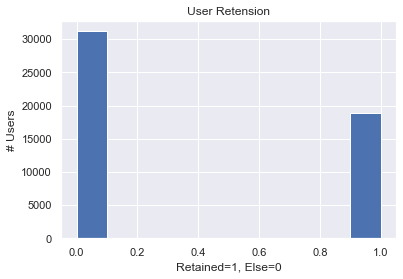

In [200]:
plt.hist(ult['retained'])
plt.xlabel('Retained=1, Else=0')
plt.ylabel('# Users')
plt.title('User Retension')
plt.show()

In [110]:
# retained users = number of users that took a trip within 30 days of July 1st 2014 / total number of users
retained = ult['retained'].sum() / ult['retained'].count()
print(retained*100)

37.608000000000004


The retention rate is around 37.61%. There is some imbalance in the data, so the metric for evaluation I chose is the F1 score and the precision-recall curve AUC.

### Prediction Models

I use the following models:
- Logistic Regression (LR)
- K-Nearest Neighbor (KNN)
- Support Vector Machine (SVM)
- Random Forest (RF)
  
KNN and SVM require the data to be scaled while LR and RF do not.

In [263]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, auc

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [111]:
# split into target and features
y = ult['retained']
X = ult.drop('retained', axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [151]:
# scale data using standard scaler
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [215]:
# function to plot precision-recall curve:
def plotPR(y_test, y_pred, y_pred_prob, model):
    p, r, _ = precision_recall_curve(y_test, y_pred_prob)

    plt.plot(p, r)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(model + ' Precision-Recall Curve')
    plt.show()
    
    f1, auc_score = f1_score(y_test, y_pred), auc(r, p)
    print(model + ' F1 score:', f1)
    print(model + ' AUC: ', auc_score)

#### Logistic Regression

In [260]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [217]:
# fit default logistic regression (C=1)
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

# predict test values
y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7918 1461]
 [2809 2812]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      9379
           1       0.66      0.50      0.57      5621

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



In [221]:
# tune for C regularization parameter

Cs = [0.001, 0.1, 1, 10, 100]
parameters = {'C': Cs}

lr = LogisticRegression(solver='lbfgs', max_iter=1000)

clf = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='f1')
clf.fit(X_train, y_train)

print('Best C: {}'.format(clf.best_params_)) 
print('Best cv score: {}'.format(clf.best_score_))

Best C: {'C': 10}
Best cv score: 0.5691396958521391


In [222]:
# predict test values
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7918 1461]
 [2808 2813]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      9379
           1       0.66      0.50      0.57      5621

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



There's not much difference between using c=1 (default) and c=10 (tuned). The tuned model is slightly better at predicting the test set compared to the default. FN decreases by 1, TN increases by 1.

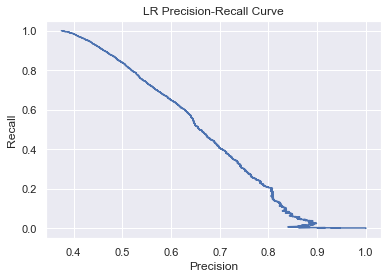

LR F1 score: 0.5685699848408287
LR AUC:  0.65716324457421


In [223]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

plotPR(y_test, y_pred, y_pred_prob, 'LR')

#### K Nearest Neighbors

In [259]:
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [218]:
# fit default knn (K=5)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# predict test values
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7548 1831]
 [2092 3529]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9379
           1       0.66      0.63      0.64      5621

    accuracy                           0.74     15000
   macro avg       0.72      0.72      0.72     15000
weighted avg       0.74      0.74      0.74     15000



In [224]:
# tune for K number of neighbors

Ks = list(range(1,30))
parameters = {'n_neighbors': Ks}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, param_grid=parameters, cv=5, scoring='f1')
clf.fit(X_train, y_train)

print('Best C: {}'.format(clf.best_params_)) 
print('Best cv score: {}'.format(clf.best_score_))

Best C: {'n_neighbors': 29}
Best cv score: 0.6666590711795909


In [225]:
# predict test values
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7818 1561]
 [2041 3580]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      9379
           1       0.70      0.64      0.67      5621

    accuracy                           0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



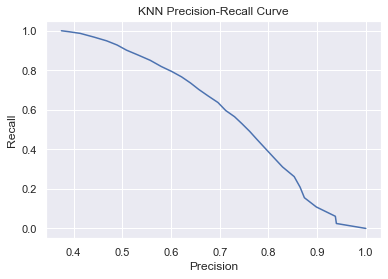

KNN F1 score: 0.6653038468686119
KNN AUC:  0.7331792027155518


In [227]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

plotPR(y_test, y_pred, y_pred_prob, 'KNN')

#### SVM

In [234]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [246]:
svc = SVC()
svc.fit(X_train, y_train)

# predict test values
y_pred = svc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8106 1273]
 [2276 3345]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      9379
           1       0.72      0.60      0.65      5621

    accuracy                           0.76     15000
   macro avg       0.75      0.73      0.74     15000
weighted avg       0.76      0.76      0.76     15000



In [254]:
print('SVM F1 score:', f1_score(y_test, y_pred))

SVM F1 score: 0.6533841195429241


In [ ]:
# tuning for SVC Parameters <-- Did not finish running (took too long)
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf', 'poly', 'sigmoid']

parameters = {'C': Cs, 'gamma': gammas, 'kernel': kernels}

svc = SVC()
clf = GridSearchCV(svc, param_grid=parameters, cv=5)
clf.fit(X_train, y_train)

print('Best C: {}'.format(clf.best_estimator_)) 
print('Best cv score: {}'.format(clf.best_score_))

#### Random Forest

In [258]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [278]:
# fit default Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# predict test values
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/Users/meiliu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[7694 1685]
 [2179 3442]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      9379
           1       0.67      0.61      0.64      5621

    accuracy                           0.74     15000
   macro avg       0.73      0.72      0.72     15000
weighted avg       0.74      0.74      0.74     15000



In [281]:
# tune parameters <-- quick tuning using RandomizedSearchCV n_iter=10 (default) to save time, ideally use more
parameters = {'max_depth': [50, 80, 90, 100, 110],
            'min_samples_leaf': [1, 3, 5, 10],
            'min_samples_split': [2, 4, 8, 15],
            'n_estimators': [50, 100, 200, 400, 1000]}

rf = RandomForestClassifier(random_state=42)

clf = RandomizedSearchCV(rf, param_distributions=parameters, cv=5, scoring='f1')
clf.fit(X_train, y_train)

print('Best C: {}'.format(clf.best_params_)) 
print('Best cv score: {}'.format(clf.best_score_))

Best C: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 110}
Best cv score: 0.6966261773872495


In [282]:
# predict test values
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8042 1337]
 [1959 3662]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9379
           1       0.73      0.65      0.69      5621

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



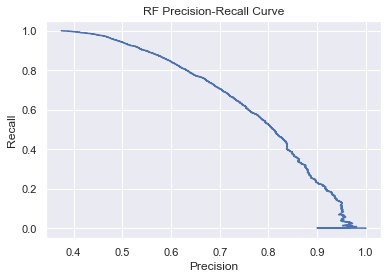

RF F1 score: 0.6896421845574388
RF AUC:  0.7747291630299405


In [283]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

plotPR(y_test, y_pred, y_pred_prob, 'RF')

In [310]:
importance = clf.best_estimator_.feature_importances_
features = list(ult.drop('retained', axis=1).columns)
important_features = pd.Series(importance, index=features)

important_features.sort_values(ascending=False)

avg_rating_by_driver      0.154562
weekday_pct               0.143579
avg_dist                  0.137654
surge_pct                 0.106045
avg_surge                 0.087174
city_King's Landing       0.083858
trips_in_first_30_days    0.072453
avg_rating_of_driver      0.054692
ultimate_black_user       0.049835
phone_iPhone              0.034146
phone_Android             0.031613
city_Astapor              0.026755
city_Winterfell           0.017635
dtype: float64

The model with the highest F1 score and AUC of precision-recall curve is the (lightly) tuned random forest model. I chose to evaluate the models with the F1 and AUC of the precision-recall curve since the dataset is imbalanced (greater amount of non-retained riders). The accuracy of the model is around 78%. The model might be improved by dealing with some outliers identified in the EDA. 
  
The 5 most important features are avg_rating_by_driver, weekday_pct, avg_dist, avg_surge, and avg_surge.